#### Script to extract tables from advice PDFs

Camelot works much better to identify the tables correctly compared to tabula, but some tweaks are needed. Especially, line_scale is required as some lines are too small for the default reader.

Problems
1. The case when there is a range and no single value is given (e.g. advice in sol.27.4)
2. Unknown behaviour: camelot doesn't recognize some cells (e.g. before 1990 in sol.27.7d)

In [237]:
import os
# import tabula
import pandas as pd
import PyPDF2
import re
import camelot
import numpy as np

In [157]:
stockA = pd.read_csv("../data/stockAssesment2022/StockAssessment.csv")

C:\Users\isaldiviagonzatti\AppData\Local\Temp\ipykernel_2504\3791297337.py:1: DtypeWarning: Columns (55,63,98,99,101,102,104,105,107,108,110,111,113,114,116,117,119,120,122,123,125,126,128,129,131,132) have mixed types. Specify dtype option on import or set low_memory=False.
  stockA = pd.read_csv("../data/stockAssesment2020/StockAssessment.csv")


In [158]:
stockA[stockA['StockDescription'].str.contains("Blue ling")].StockDescription.unique()

array(['Blue ling (Molva dypterygia) in subareas 6-7 and Division 5.b (Celtic Seas and Faroes grounds)'],
      dtype=object)

In [2072]:
# read files in directory
os.listdir('../data/missingICESpdfs')

['cod.21.1.pdf',
 'cod.27.1-2.pdf',
 'cod.27.21.pdf',
 'cod.27.22-24.pdf',
 'cod.27.47d20.pdf',
 'ghl.27.561214.pdf',
 'had.27.1-2.pdf',
 'had.27.46a20.pdf',
 'had.27.5a.pdf',
 'had.27.6b.pdf',
 'had.27.7a.pdf',
 'had.27.7b-k.pdf',
 'her.27.1-24a514a.pdf',
 'her.27.20-24.pdf',
 'her.27.25-2932.pdf',
 'her.27.28.pdf',
 'her.27.3031.pdf',
 'her.27.3a47d.pdf',
 'her.27.5a.pdf',
 'her.27.6a7bc.pdf',
 'her.27.irls.pdf',
 'her.27.nirs.pdf',
 'hke.27.3a46-8abd.pdf',
 'hke.27.8c9a.pdf',
 'hom.27.2a4a5b6a7a-ce-k8.pdf',
 'hom.27.9a.pdf',
 'ldb.27.8c9a.pdf',
 'lez.27.4a6a.pdf',
 'lez.27.6b.pdf',
 'lin.27.5a.pdf',
 'mac.27.nea.pdf',
 'meg.27.7b-k8abd.pdf',
 'meg.27.8c9a.pdf',
 'nop.27.3a4.pdf',
 'ple.27.7a.pdf',
 'pra.27.1-2.pdf',
 'pra.27.3a4a.pdf',
 'reg.27.1-2.pdf',
 'reg.27.561214.pdf']

In [1983]:
fishStock = 'sol.27.7fg' 

In [1984]:
# get page number in which Table 6 lies, and also get the next one as tables can span two oages
obj = PyPDF2.PdfFileReader("../data/pdfsICES/{}.pdf".format(fishStock))

pgno = obj.getNumPages()

#in some pdfs the Table 6 has more than one space between Table and 6
s = "Table[ ]{1,}6" 

for i in range(0, pgno):
    PgOb = obj.getPage(i)
    Text = PgOb.extractText()
    if re.search(s,Text):
         pages=str(i+1) + ',' + str(i+2)
         print(pages)

4,5


In [1985]:
# from camelot import utils
# layout, dim = utils.get_page_layout(r'C:\Users\isaldiviagonzatti\Downloads\pdfsICES\spr.27.3a4.pdf')

In [1986]:
# read tables with Camelot. Using backend="poppler" as Ghostscript is not working for me
# table_area is not providing the expected results
# iterations had no effect for me
tables = camelot.read_pdf("../data/pdfsICES/{}.pdf".format(fishStock), 
                           pages=pages, 
                           backend="poppler", 
                           # flavor='stream',
                           # # table_areas accepts strings of the form x1,y1,x2,y2 where (x1, y1) -> top-left and (x2, y2)
                           # table_area=['0,600,590,700'],
                           # iterations=1,
                           line_scale=30,
                           # split_text=True,
                           strip_text=['#','^','<', '-', '≤', '***', '\n'],
                          )
print("Total tables extracted:", tables.n)

Total tables extracted: 6


In [1987]:
# delete tables before the first table in list that corresponds to table 6 (Advice) 
firstAdvice = [i for i, elem in enumerate(tables) if 'ICES advice' \
    in tables[i].df.iloc[0,:].to_list()][0]
tables = tables[firstAdvice:]

In [2063]:
# filter tables by two conditions:
# [0][0] is numeric and len(columns) is equal to the len(first table 6) 
# or the first row is equal to the first row of the first table 6

filterTableSix = [i for i, elem in enumerate(tables) if (pd.to_numeric\
    (tables[i].df[0].str.extract('(\d+)')[0][0], errors='coerce') > 0\
    and len(tables[i].df.columns) == len(tables[0].df.columns))\
    or tables[i].df.iloc[0,:].equals(tables[0].df.iloc[0,:]) == True
]

tableSix = [tables[i].df for i in filterTableSix]
tableSix = pd.concat(tableSix).reset_index(drop=True)

In [2064]:
# fix table 
icesTable = tableSix.copy()
icesTable.columns = icesTable.iloc[0,:]
icesTable = icesTable[1:].reset_index(drop=True)
icesTable['fishStock'] = fishStock
# sometimes the columns Year and ICES advice (text) don't split, we strip the text
icesTable['Year'] = icesTable['Year'].str.extract('(\d+)', expand=False)
icesTable = icesTable[icesTable['Year'].astype(str).str.isnumeric()]

# sometimes there is more than one space between the words in the columns
icesTable.rename(columns=lambda x: re.sub(r' +', ' ', x).strip(), inplace=True) # '[^a-zA-Z]+'

# replace columns names
dictCol = {'(?=.*[Cc]atch)(?=.*[Aa]dvice)': 'SAD', 
            '(?=.*[Ll]anding)(?=.*[Aa]dvice)': 'SAD_landings',
            '(?=.*TAC)': 'TAC',
            '(?=.*ICES)(?=.*[Ll]anding)': 'Landings',
            '(?=.*ICES)(?=.*[Cc]atch)': 'Catches (pdfs)',
            '(?=.*ICES)(?=.*[Dd]iscards)': 'Discards',} 

for key, value in dictCol.items():
    countCol = []
    for i in range(len(icesTable.columns.to_list())):
        count = bool(re.search(key, icesTable.columns[i]))
        countCol.append(count)
    # if more than one column name matches the regex, we don't rename them
    if countCol.count(True) == 1:
        for i in range(len(icesTable.columns.to_list())):
            if bool(re.search(key, icesTable.columns[i])) == True:
                icesTable.rename(columns = {icesTable.columns[i]:value}, inplace = True)

# fix numeric columns
numericCol = ['SAD', 'SAD_landings', 'TAC', 'Landings', 
'Year', 'Catches (pdfs)', 'Discards']
for col in icesTable.columns:
    if col in numericCol:
        # strip spaces between numbers
        icesTable[col] = icesTable[col].replace({' ': ''}, regex=True)
        # for cases in which there is an explanation of the number, we strip it
        icesTable[col] = icesTable[col].str.split('(').str[0]
        icesTable[col] = icesTable[col].apply(pd.to_numeric, errors='coerce')

icesTable = icesTable.replace({'': np.nan})

# if there is no SAD catch, we use SAD_landings
if 'SAD_landings' in icesTable.columns:
    icesTable['SAD'] = icesTable['SAD'].fillna(icesTable['SAD_landings'])

# define catches as landing + discards
if 'Landings' in icesTable.columns and 'Discards' in icesTable.columns:
    icesTable['catchesCal'] = icesTable['Landings'].fillna(0) + icesTable['Discards'].fillna(0)

# if there is no ICES Catches, we use catchCal
if 'Catches (pdfs)' in icesTable.columns:
    icesTable['Catches (pdfs)'] = icesTable['Catches (pdfs)'].fillna(icesTable['catchesCal'])
else:
    icesTable['Catches (pdfs)'] = icesTable['catchesCal']

    
icesTable.reset_index(drop=True, inplace=True)
icesTable

,Year,ICES advice,SAD,SAD_landings,TAC,Official landings,Landings,Discards,fishStock,catchesCal,Catches (pdfs)
0,1987,Status quo F; TAC,1600.0,1600.0,1600.0,1264,1222.0,NaN,sol.27.7fg,1222.0,1222.0
1,1988,F = F (pre86); TAC,900.0,900.0,1100.0,1204,1146.0,NaN,sol.27.7fg,1146.0,1146.0
2,1989,F at F (81–85); TAC,1000.0,1000.0,1000.0,992,992.0,NaN,sol.27.7fg,992.0,992.0
3,1990,No increase in F,1200.0,1200.0,1200.0,1239,1189.0,NaN,sol.27.7fg,1189.0,1189.0
4,1991,No increase in F,1100.0,1100.0,1200.0,1496,1107.0,NaN,sol.27.7fg,1107.0,1107.0
5,1992,No longterm gains in increasing F,1100.0,1100.0,1200.0,1060,981.0,NaN,sol.27.7fg,981.0,981.0
6,1993,No longterm gains in increasing F,NaN,NaN,1100.0,1030,928.0,NaN,sol.27.7fg,928.0,928.0
7,1994,No longterm gains in increasing F,NaN,NaN,1100.0,1018,1009.0,NaN,sol.27.7fg,1009.0,1009.0
8,1995,No increase in F,1000.0,1000.0,1100.0,1165,1157.0,NaN,sol.27.7fg,1157.0,1157.0
9,1996,20% reduction in F,800.0,800.0,1000.0,1081,995.0,NaN,sol.27.7fg,995.0,995.0


In [2065]:
# Sandeel case
if 'san.sa' in fishStock:
    icesTable = icesTable.loc[:, ~icesTable.columns.str.contains('(?=.*[Tt]otal)(?=.*[Cc]atch)')]
    icesCatches = icesTable.columns.str.contains('(?=.*ICES)(?=.*[Cc]atch)')
    icesTable.iloc[:,np.where(icesCatches)[0][1]].fillna(icesTable.iloc[:,np.where(icesCatches)[0][0]], inplace=True)
    icesTable = icesTable.drop(columns=[icesTable.iloc[:,np.where(icesCatches)[0][0]].name])
    icesTable = icesTable.rename(columns={icesTable.iloc[:,np.where(icesCatches)[0][0]].name: 'Catches (pdfs)'})
    icesTable

In [2066]:
# drop one year to test
icesTable = icesTable[icesTable['Year'] != 2020]

In [2067]:
# check if all years were read correctly by Camelot
checkYear = pd.Series(np.arange(icesTable.Year.iloc[0], icesTable.Year.iloc[-1]+1))
missingYear = checkYear[~checkYear.isin(icesTable.Year)].to_list()
if missingYear:
    allYears = pd.DataFrame(list(range(min(icesTable.Year), max(icesTable.Year+1))), columns=['Year'])
    icesTable = icesTable.merge(allYears, how='outer', on='Year').sort_values(by='Year').reset_index(drop=True)
    icesTable['missingYear'] = np.where(icesTable.fishStock.isnull(),'missing', np.nan)
    print('Years', missingYear, 'were not read correctly')
else:
    print('All years were read correctly')

Years [2020] were not read correctly


In [2068]:
# check for years that were not read because there is a SAD range 
specialYear = []
icesTable['missingSAD'] = np.nan
for value in range(len(icesTable['SAD']))[1:-1]:
        if np.isnan(icesTable['SAD'][value])\
        and ~np.isnan(icesTable['SAD'][value-1])\
        and ~np.isnan(icesTable['SAD'][value+1]): 
            specialYear.append(value)
            icesTable.loc[value, 'missingSAD'] = 'missing'
if specialYear != []:
    print('Year(s)', icesTable['Year'][specialYear].values.tolist(), 'is a special case')
else:
    print('All years have a specific SAD value')

Year(s) [2011, 2020] is a special case


In [2069]:
# add columns from excel and reorganize
excelTable = (icesTable.reindex(['fishStock', 
'Most recent assessment with corresponding report',
 'Year','Catches (stockass)', 'SAD','TAC', 
 'Catches (pdfs)','done?', 'report','SAD_landings',
 'Landings','Discards','catchesCal','missingYear','missingSAD'], axis=1))
    
# icesTable = icesTable.replace('','N/A')
excelTable.set_index('fishStock', inplace=True)
excelTable.to_csv("../dataTemp/icesAdvice/{}.csv".format(fishStock))
excelTable

,Most recent assessment with corresponding report,Year,Catches (stockass),SAD,TAC,Catches (pdfs),done?,report,SAD_landings,Landings,Discards,catchesCal,missingYear,missingSAD
fishStock,,,,,,,,,,,,,,
sol.27.7fg,NaN,1987,NaN,1600.0,1600.0,1222.0,NaN,NaN,1600.0,1222.0,NaN,1222.0,nan,NaN
sol.27.7fg,NaN,1988,NaN,900.0,1100.0,1146.0,NaN,NaN,900.0,1146.0,NaN,1146.0,nan,NaN
sol.27.7fg,NaN,1989,NaN,1000.0,1000.0,992.0,NaN,NaN,1000.0,992.0,NaN,992.0,nan,NaN
sol.27.7fg,NaN,1990,NaN,1200.0,1200.0,1189.0,NaN,NaN,1200.0,1189.0,NaN,1189.0,nan,NaN
sol.27.7fg,NaN,1991,NaN,1100.0,1200.0,1107.0,NaN,NaN,1100.0,1107.0,NaN,1107.0,nan,NaN
sol.27.7fg,NaN,1992,NaN,1100.0,1200.0,981.0,NaN,NaN,1100.0,981.0,NaN,981.0,nan,NaN
sol.27.7fg,NaN,1993,NaN,NaN,1100.0,928.0,NaN,NaN,NaN,928.0,NaN,928.0,nan,NaN
sol.27.7fg,NaN,1994,NaN,NaN,1100.0,1009.0,NaN,NaN,NaN,1009.0,NaN,1009.0,nan,NaN
sol.27.7fg,NaN,1995,NaN,1000.0,1100.0,1157.0,NaN,NaN,1000.0,1157.0,NaN,1157.0,nan,NaN


In [1773]:
# sum of spr.27.3a and spr.27.4 
spr4 = pd.read_csv("../dataTemp/icesAdvice/spr.27.4.csv")
spr3a = pd.read_csv("../dataTemp/icesAdvice/spr.27.3a.csv")
col_list = spr3a.columns.tolist()
spr4, spr3a = (df.set_index(['Year']).drop(columns=['fishStock']) for df in [spr4, spr3a])
spr3aHist = spr3a.add(spr4, fill_value=0)
spr3aHist['fishStock'] = 'spr.27.3a4'
spr3aHist.reset_index(inplace=True)
spr3aHist = spr3aHist[col_list]
spr3aHist.to_csv("../dataTemp/icesAdvice/spr.27.3a4bis.csv", index=False)

In [1780]:
# concat all the stock extracted
listStock = os.listdir('../dataTemp/icesAdvice/')
listStock = [ '../dataTemp/icesAdvice/' + s for s in listStock]
listStock
allStock = pd.DataFrame()
allStock = pd.concat([pd.read_csv(f) for f in listStock ])
allStock.to_csv( "../dataTemp/adviceExtract.csv", index=False)

C:\Users\isaldiviagonzatti\AppData\Local\Temp\ipykernel_2504\3259206825.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  camelot.plot(tables[0], kind='text').show()


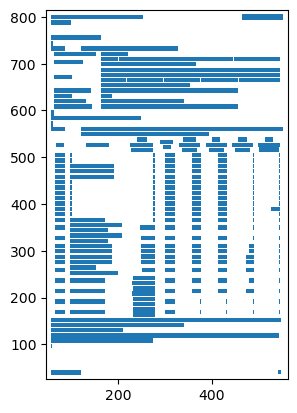

In [940]:
camelot.plot(tables[0], kind='text').show()

#### Trash

In [ ]:
# if len(tables) > 1:
#     # if table in same page is divided in two, then concatenate
#     if pd.to_numeric(tables[1].df[0][0], errors='coerce')> 0:
#         tableSix = pd.concat([tables[0].df, tables[1].df])
#     # if table is divided in two pages, then concatenate
#     elif tables[1].df.iloc[0,:].equals(tables[0].df.iloc[0,:]) == True:
#         tableSix = pd.concat([tables[0].df, tables[1].df])
#     else:
#         tableSix = tables[0].df
# if len(tables) > 2:
#     # if table is divided in two pages, then concatenate
#     if tables[2].df.iloc[0,:].equals(tables[0].df.iloc[0,:]) == True:
#         tableSix = pd.concat([tableSix, tables[2].df])
#     elif pd.to_numeric(tables[2].df[0][0], errors='coerce')> 0:
#         tableSix = pd.concat([tableSix, tables[2].df])
        
# tableSix

#### From tabula

In [162]:
# tables = tabula.read_pdf(r"C:\Users\isaldiviagonzatti\Downloads\pdfsICES\spr.27.3a4.pdf", multiple_tables=True, 
#                           pages=page, lattice=True, guess=True, java_options="-Dfile.encoding=UTF8")                        


In [159]:
# tabula.convert_into("file:///C:/Users/isaldiviagonzatti/OneDrive%20-%20Kiel%20Institut%20f%C3%BCr%20Weltwirtschaft/Documents/General/Ignacio/data/pdf_ices_test/bli.27.5b67.pdf", r"C:/Users/isaldiviagonzatti//Downloads/test.csv", output_format="csv", stream=True, pages='4')

In [ ]:
# i=1
# for table in tables:
#     table.columns = table.iloc[0]
#     table = table.reindex(table.index.drop(0)).reset_index(drop=True)
#     table.columns.name = None
#     #To write Excel
#     table.to_excel('output'+str(i)+'.xlsx',header=True,index=False)
#     #To write CSV
#     table.to_csv('output'+str(i)+'.csv',sep='|',header=True,index=False)
#     i=i+1